# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = '/Users/no_love_no_problem/cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

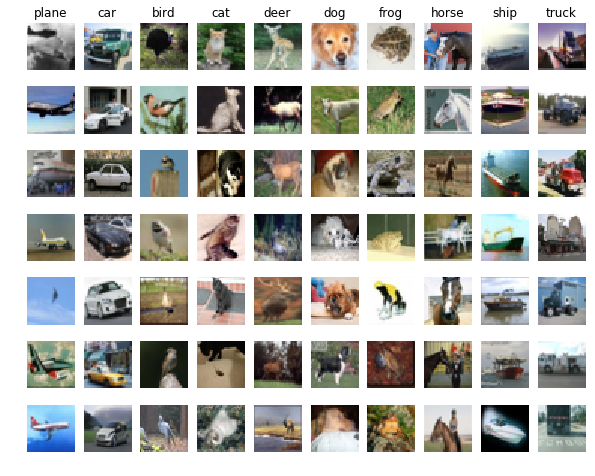

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

In [5]:
input_layer = lasagne.layers.InputLayer(shape=(None,3, 32, 32), input_var=input_X)

nnet = lasagne.layers.Conv2DLayer(input_layer, num_filters=64, filter_size=(5, 5), nonlinearity=rectify)
nnet = lasagne.layers.MaxPool2DLayer(nnet, pool_size=(2, 2))
nnet = lasagne.layers.Conv2DLayer(nnet, num_filters=64, filter_size=(3, 3), nonlinearity=rectify)
nnet = lasagne.layers.MaxPool2DLayer(nnet, pool_size=(2, 2))
nnet = lasagne.layers.Conv2DLayer(nnet, num_filters=64, filter_size=(3, 3), nonlinearity=rectify)
nnet = lasagne.layers.MaxPool2DLayer(nnet, pool_size=(2, 2))
nnet = lasagne.layers.DenseLayer(nnet,num_units=64, nonlinearity=rectify)

dense_output = lasagne.layers.DenseLayer(nnet,num_units = 10, nonlinearity=softmax)

In [6]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [7]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, W, b, W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [8]:
# подсказка - смотри lasagne.objectives... 
# не забудь взять среднее

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [9]:
# выбери наобум оптимизатор из lasagne.updates...
# но лучше прочитай про разные оптимизаторы вот здесь например: 
# http://sebastianruder.com/optimizing-gradient-descent/index.html#adam

params = lasagne.layers.get_all_params(dense_output, trainable=True)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=lasagne.updates.adam(loss, params), allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [11]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

theano.config.exception_verbosity='high'

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train ,batch_size):
        inputs, targets = batch
        inputs = inputs.transpose(0,3,1,2)
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        inputs = inputs.transpose(0,3,1,2)
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 10 took 337.765s
  training loss (in-iteration):		1.951751
  train accuracy:		37.03 %
  validation accuracy:		47.80 %
Epoch 2 of 10 took 302.578s
  training loss (in-iteration):		1.411518
  train accuracy:		49.67 %
  validation accuracy:		51.83 %
Epoch 3 of 10 took 307.897s
  training loss (in-iteration):		1.280065
  train accuracy:		55.06 %
  validation accuracy:		56.78 %
Epoch 4 of 10 took 295.727s
  training loss (in-iteration):		1.188831
  train accuracy:		58.46 %
  validation accuracy:		57.30 %
Epoch 5 of 10 took 296.621s
  training loss (in-iteration):		1.124069
  train accuracy:		60.85 %
  validation accuracy:		60.28 %
Epoch 6 of 10 took 336.932s
  training loss (in-iteration):		1.073210
  train accuracy:		62.40 %
  validation accuracy:		60.89 %
Epoch 7 of 10 took 354.508s
  training loss (in-iteration):		1.019565
  train accuracy:		64.48 %
  validation accuracy:		60.81 %
Epoch 8 of 10 took 345.609s
  training loss (in-iteration):		0.977288
  train accuracy:		65.86 %


In [12]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    inputs = inputs.transpose(0,3,1,2)
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		64.05 %
Нужно больше магии!
